In [13]:
import torch
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rk7VDaPjMp1h5VXS-cUyMg/league-of-legends-data-large.csv -O dataset/league_of_legends_data.csv

--2025-06-24 02:18:48--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rk7VDaPjMp1h5VXS-cUyMg/league-of-legends-data-large.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29451 (29K) [text/csv]
Saving to: ‘dataset/league_of_legends_data.csv’

dataset/league_of_l 100%[===================>]  28.76K  --.-KB/s    in 0.08s   

2025-06-24 02:18:50 (362 KB/s) - ‘dataset/league_of_legends_data.csv’ saved [29451/29451]



In [14]:
df = pd.read_csv('dataset/league_of_legends_data.csv')
df.head()

,win,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,0,16,6,19,17088,231,11,7,15367
1,1,8,8,5,14865,259,10,2,38332
2,0,0,17,11,15919,169,14,5,24642
3,0,19,11,1,11534,264,14,3,15789
4,0,12,7,6,18926,124,15,7,40268


In [15]:
y = df['win'] # Target variable
X = df.drop(columns=['win']) # Features

# Task 1: Load and preprocess the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Check shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 8]),
 torch.Size([800, 1]),
 torch.Size([200, 8]),
 torch.Size([200, 1]))

In [16]:
# Task 2: Implement a logistic regression model using PyTorch

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        return self.sigmoid(x)

# Initialize the model
model = LogisticRegressionModel(input_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.2934, -0.0899,  0.2817,  0.1063,  0.2496, -0.0246,  0.3253,  0.0722]],
                     device='cuda:0')),
             ('linear.bias', tensor([0.0423], device='cuda:0'))])

In [17]:
# Task 3: Train the logistic regression model on the dataset.
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    # Evaluate accuracy every 100 epochs
    if epoch % 100 == 0:
        with torch.inference_mode():

            # Convert predictions to 0 or 1 for accuracy calculation
            y_pred_train = (predictions >= 0.5).float()
            train_accuracy = (y_pred_train.eq(y_train).sum().item()) / y_train.size(0)

            model.eval()
            y_pred_test = (model(X_test) >= 0.5).float()
            test_accuracy = (y_pred_test.eq(y_test).sum().item()) / y_test.size(0)
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Train Accuracy={train_accuracy:.4f} Test Accuracy={test_accuracy:.4f}")

Epoch 0: Loss=0.2752, Train Accuracy=0.4688 Test Accuracy=0.5300
Epoch 100: Loss=0.2461, Train Accuracy=0.5437 Test Accuracy=0.5050
Epoch 200: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050
Epoch 300: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050
Epoch 400: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050
Epoch 500: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050
Epoch 600: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050
Epoch 700: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050
Epoch 800: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050
Epoch 900: Loss=0.2461, Train Accuracy=0.5463 Test Accuracy=0.5050


In [18]:
model = LogisticRegressionModel(input_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.3109,  0.2797,  0.0638, -0.1560,  0.1813, -0.1774, -0.1401, -0.1790]],
                     device='cuda:0')),
             ('linear.bias', tensor([-0.1199], device='cuda:0'))])

In [19]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    # Evaluate accuracy every 100 epochs
    if epoch % 100 == 0:
        with torch.inference_mode():

            # Convert predictions to 0 or 1 for accuracy calculation
            y_pred_train = (predictions >= 0.5).float()
            train_accuracy = (y_pred_train.eq(y_train).sum().item()) / y_train.size(0)

            model.eval()
            y_pred_test = (model(X_test) >= 0.5).float()
            test_accuracy = (y_pred_test.eq(y_test).sum().item()) / y_test.size(0)
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Train Accuracy={train_accuracy:.4f} Test Accuracy={test_accuracy:.4f}")

Epoch 0: Loss=0.2797, Train Accuracy=0.4625 Test Accuracy=0.4800
Epoch 100: Loss=0.2736, Train Accuracy=0.4713 Test Accuracy=0.4750
Epoch 200: Loss=0.2683, Train Accuracy=0.4675 Test Accuracy=0.4600
Epoch 300: Loss=0.2637, Train Accuracy=0.4688 Test Accuracy=0.4650
Epoch 400: Loss=0.2599, Train Accuracy=0.4713 Test Accuracy=0.4950
Epoch 500: Loss=0.2568, Train Accuracy=0.4788 Test Accuracy=0.5050
Epoch 600: Loss=0.2543, Train Accuracy=0.4888 Test Accuracy=0.5150
Epoch 700: Loss=0.2524, Train Accuracy=0.5062 Test Accuracy=0.5150
Epoch 800: Loss=0.2509, Train Accuracy=0.5225 Test Accuracy=0.5050
Epoch 900: Loss=0.2498, Train Accuracy=0.5238 Test Accuracy=0.4950


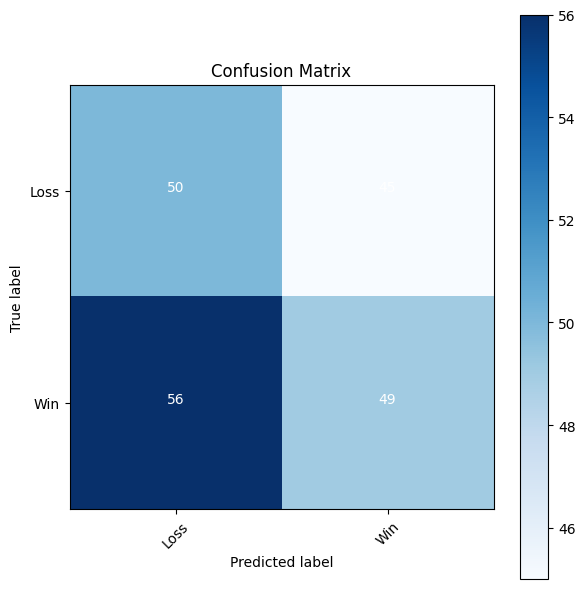

Classification Report:
               precision    recall  f1-score   support

        Loss       0.47      0.53      0.50        95
         Win       0.52      0.47      0.49       105

    accuracy                           0.49       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.50      0.49      0.49       200



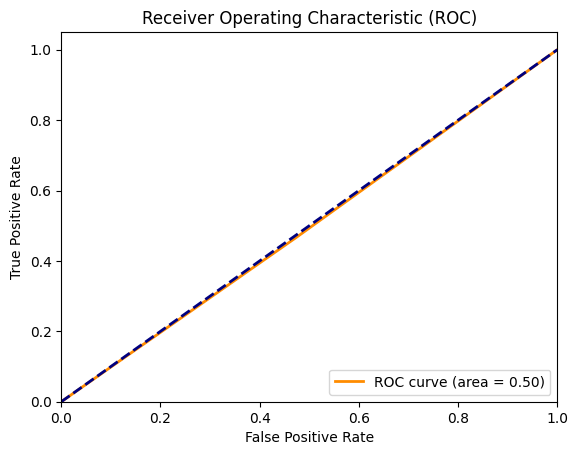

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

# Visualize the confusion matrix
#Change the variable names as used in your code
y_pred_test_labels = (y_pred_test.to('cpu') > 0.5).float()
cm = confusion_matrix(y_test.to('cpu'), y_pred_test_labels)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test.to('cpu'), y_pred_test_labels, target_names=['Loss', 'Win']))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test.to('cpu'), y_pred_test.to('cpu'))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [21]:
torch.save(model.state_dict(), 'model.pth')

In [22]:
# Load the model
model = LogisticRegressionModel(X_train.shape[1]).to(device)
model.load_state_dict(torch.load('model.pth'))

# Ensure the loaded model is in evaluation mode
model.eval()

# Evaluate the loaded model
with torch.inference_mode():
  y_pred_test = model(X_test)
  y_pred_test_labels = (y_pred_test >= 0.5).float()
  test_accuracy = (y_pred_test_labels.eq(y_test).sum().item()) / y_test.size(0)
  print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.4950


In [23]:
lr_rates = [0.01, 0.05, 0.1]
epochs = 1000

for idx, lr_rate in enumerate(lr_rates):

  print(f"\n\nTraining: {idx}, Learning rate: {lr_rate}")

  model = LogisticRegressionModel(X_train.shape[1]).to(device)
  criterion = nn.BCELoss()
  optimizer = optim.SGD(model.parameters(), lr=lr_rate, weight_decay=0.01)

  for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()
      predictions = model(X_train)
      loss = criterion(predictions, y_train)
      loss.backward()
      optimizer.step()

      # Evaluate accuracy every 100 epochs
      if epoch % 100 == 0:
          with torch.inference_mode():

              # Convert predictions to 0 or 1 for accuracy calculation
              y_pred_train = (predictions >= 0.5).float()
              train_accuracy = (y_pred_train.eq(y_train).sum().item()) / y_train.size(0)

              model.eval()
              y_pred_test = (model(X_test) >= 0.5).float()
              test_accuracy = (y_pred_test.eq(y_test).sum().item()) / y_test.size(0)
              print(f"Epoch {epoch}: Loss={loss.item():.4f}, Train Accuracy={train_accuracy:.4f} Test Accuracy={test_accuracy:.4f}")



Training: 0, Learning rate: 0.01
Epoch 0: Loss=0.7356, Train Accuracy=0.4838 Test Accuracy=0.4900
Epoch 100: Loss=0.7157, Train Accuracy=0.4750 Test Accuracy=0.4700
Epoch 200: Loss=0.7034, Train Accuracy=0.5025 Test Accuracy=0.4700
Epoch 300: Loss=0.6961, Train Accuracy=0.5162 Test Accuracy=0.4600
Epoch 400: Loss=0.6917, Train Accuracy=0.5337 Test Accuracy=0.4650
Epoch 500: Loss=0.6891, Train Accuracy=0.5325 Test Accuracy=0.4800
Epoch 600: Loss=0.6875, Train Accuracy=0.5312 Test Accuracy=0.4900
Epoch 700: Loss=0.6866, Train Accuracy=0.5400 Test Accuracy=0.5100
Epoch 800: Loss=0.6861, Train Accuracy=0.5413 Test Accuracy=0.5100
Epoch 900: Loss=0.6858, Train Accuracy=0.5487 Test Accuracy=0.5150


Training: 1, Learning rate: 0.05
Epoch 0: Loss=0.7555, Train Accuracy=0.5038 Test Accuracy=0.4950
Epoch 100: Loss=0.6916, Train Accuracy=0.5288 Test Accuracy=0.5250
Epoch 200: Loss=0.6859, Train Accuracy=0.5463 Test Accuracy=0.5100
Epoch 300: Loss=0.6853, Train Accuracy=0.5425 Test Accuracy=0.5

Weights: [ 0.12611873 -0.00445959 -0.01299381  0.16853935 -0.007077    0.1021425
 -0.03261068 -0.01763816], Features: Index(['kills', 'deaths', 'assists', 'gold_earned', 'cs', 'wards_placed',
       'wards_killed', 'damage_dealt'],
      dtype='object')
        Feature  Importance
3   gold_earned    0.168539
0         kills    0.126119
5  wards_placed    0.102142
1        deaths   -0.004460
4            cs   -0.007077
2       assists   -0.012994
7  damage_dealt   -0.017638
6  wards_killed   -0.032611


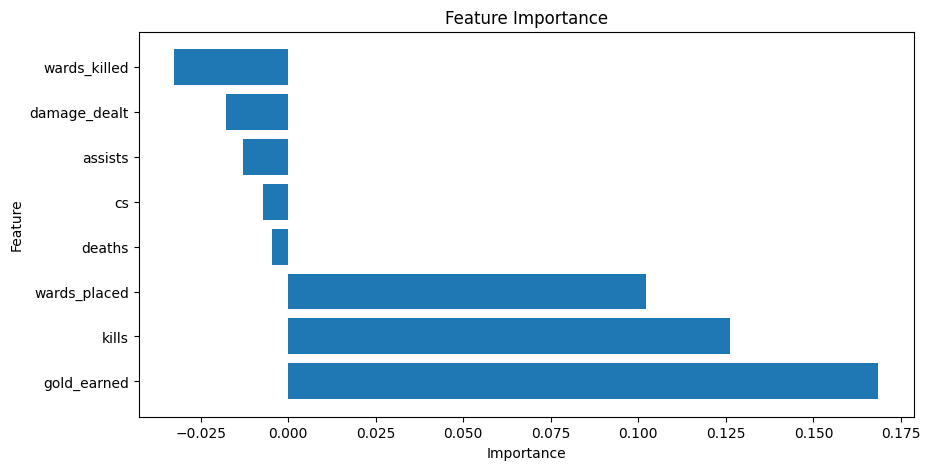

In [24]:
weights = model.to('cpu').linear.weight.data.numpy().flatten()
features = X.columns
print(f"Weights: {weights}, Features: {features}")

# Create a DataFrame for feature importance
## Write your code here
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': weights})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10,5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()